In [1]:
# tutorial from https://huggingface.co/docs/transformers/en/model_doc/vitpose
#from transformers.models.vitpose import VitPoseForPoseEstimation, VitPoseImageProcessor
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation
import torch
import requests
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365") # loads a preprocessing pipeline img (to ensure same preproc.g)
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device) # loads the object detection model:  RT-DETR object detection model (detectiion + label.g -> label 0 = person)
inputs = person_image_processor(images=image, return_tensors="pt").to(device) # preprocesses the image and returns it as a tensor
# returns an object of type <class 'transformers.image_processing_base.BatchFeature'> -> behaves like a dict e.g. inputs.keys() -> 'pixel_values' i.e. the normalized img tensor of shape 2, 3, 256, 192



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
with torch.no_grad():
    outputs = person_model(**inputs) # performs object detection on the input

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3 
) # converts raw model outputs into interpretable bounding box predictions 
# parameters:
# - (image.height, image.width) -> the original dimensions of the img to rescale the boxes accordingly
# - threshold=.3 -> keeps only the high confidence detections
# results is a list with 1 element, a dict, with the following entries: 
# 'scores' (a tensor with the confidences), 
# 'labels' (a tensor with the lables detected)
# 'boxes' (a tensor with the boxes corners)

result = results[0] # selects the first element in the list
person_boxes = result["boxes"][result["labels"] == 0] # index only the boxes associated with label 0 (person) in COCO class labels
person_boxes = person_boxes.cpu().numpy() # converts them to numpy
# converts boxes from VOC format: (x1, y1, x2, y2) to COCO format: (x, y, width, height)
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0] 
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

In [7]:
print(result)

{'scores': tensor([0.9387, 0.9143, 0.9066, 0.8970, 0.8852, 0.8419, 0.8062, 0.7861, 0.7302,
        0.7237, 0.6602, 0.6387, 0.6272, 0.6236, 0.5802, 0.5283, 0.5050, 0.4839,
        0.4323, 0.4200, 0.4125, 0.4081, 0.4074, 0.3652, 0.3470, 0.3318, 0.3306,
        0.3298]), 'labels': tensor([62, 56, 56, 75,  0, 56, 72, 75, 75, 75, 60, 74,  0, 58, 56, 62, 68, 40,
        58, 60, 75, 75, 60, 58, 56, 60, 56, 56]), 'boxes': tensor([[  5.8707, 166.3510, 154.5279, 262.9492],
        [292.8022, 217.8129, 352.1467, 318.3552],
        [361.3359, 219.5562, 416.8805, 318.0312],
        [549.9858, 307.5941, 585.7281, 401.1210],
        [417.1436, 157.0463, 464.7577, 296.4993],
        [410.5018, 219.3662, 442.4229, 305.5450],
        [490.8162, 172.9995, 513.1780, 284.6597],
        [242.0328, 197.4487, 252.7206, 212.8070],
        [350.7569, 208.0607, 362.3057, 231.0438],
        [166.6588, 232.9823, 186.4435, 268.1130],
        [319.5452, 228.9354, 388.5587, 319.3386],
        [448.2979, 120.6090, 461

In [60]:
# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple") # downloads a processor tailored for the vitpose-base-simple model, it resizes, normalizes, and formats input data (cropping each detected person), automatically includes COCO keypoint configuration.
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device) #downloads ViTPose

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device) # processes the original image using the bounding boxes -> ViTPose expects tightly cropped pics
# inputs is a dict like type with "pixels_value" as only entry. It is a tensor [Batch, Channels, Height, Width] -> Batch is the number of people detected

with torch.no_grad():
    outputs = model(**inputs) # runs ViTPose

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes]) 
# pose results is a list (len=1, num of images passed) of lists (len=Batch_size=people detected). 
# Each element is a dict with:
# - 'keypoints' -> the 2d coords of the keypoints within the img ref frame
# - 'scores' -> the confidence of each of the keypoints
# - 'labels' -> the labels of the keypoints , model.config.label2id to see the correspondence 
# - 'bbox' -> contours of the boxes 

image_pose_result = pose_results[0]  

In [58]:
print(pose_results[0][0])

{'keypoints': tensor([[428.7217, 170.6087],
        [429.4754, 167.8296],
        [428.7345, 168.1675],
        [433.8783, 167.3437],
        [441.0850, 166.8565],
        [440.0188, 177.1512],
        [446.2795, 178.3890],
        [436.8790, 197.8899],
        [433.3674, 201.2064],
        [431.4486, 218.6526],
        [420.1042, 212.7986],
        [444.8041, 224.1454],
        [452.3401, 223.9046],
        [442.2324, 256.0286],
        [451.1253, 255.1942],
        [443.1866, 288.1744],
        [456.0324, 285.7577]]), 'scores': tensor([0.9178, 0.9025, 0.7915, 0.9372, 0.9031, 0.9335, 0.7401, 0.9220, 0.5373,
        0.8782, 0.9614, 0.8090, 0.8209, 0.8292, 0.8181, 0.6038, 0.8240]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'bbox': tensor([440.9507, 226.7728, 440.6043, 226.6444])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


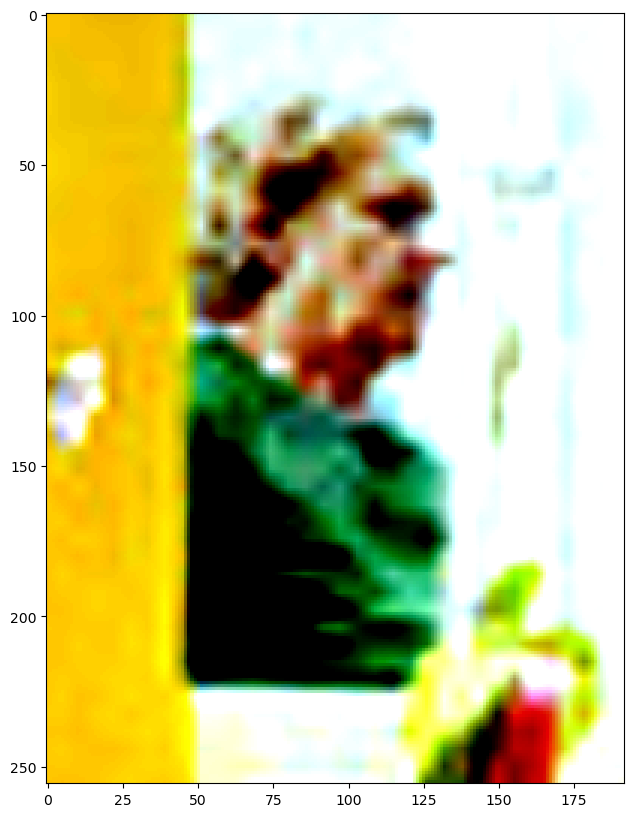

In [48]:
img = inputs["pixel_values"][1, :,:,:]
img_np = img.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10,10))
plt.imshow(img_np)

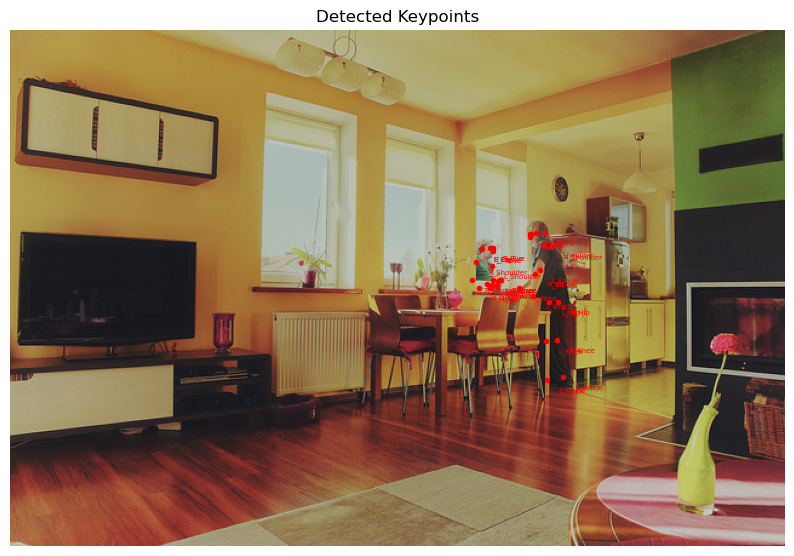

In [114]:
def plot_pose(image, boxes, img_pose_res, pers_indices, model):
    keypoint_labels = model.config.label2id 
    label_names = {v: k for k, v in keypoint_labels.items()} # reverts keys and vals of the labels so that we can retrieve properly the label names
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for pers_idx in pers_indices:
        box = boxes[pers_idx]
        keypoints = img_pose_res[pers_idx]["keypoints"]
        labels_kp = img_pose_res[pers_idx]["labels"]
        for kp_idx in range(keypoints.size()[0]):
            kps = keypoints[kp_idx, :].numpy()
            plt.plot(kps[0], kps[1], 'ro', markersize=3)
            plt.text(kps[0]+10, kps[1]+10, label_names[labels_kp[kp_idx].item()], color="red", fontsize=5)
        # # Optionally draw bounding box
        # x, y, w, h = box
        # rect = plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=1)
        # plt.gca().add_patch(rect)
    
    plt.axis('off')
    plt.title("Detected Keypoints")
    plt.show()

plot_pose(image, person_boxes, image_pose_result, [0, 1], model)

In [88]:
range(17)

range(0, 17)

In [89]:
model.config.label2id 

{'L_Ankle': 15,
 'L_Ear': 3,
 'L_Elbow': 7,
 'L_Eye': 1,
 'L_Hip': 11,
 'L_Knee': 13,
 'L_Shoulder': 5,
 'L_Wrist': 9,
 'Nose': 0,
 'R_Ankle': 16,
 'R_Ear': 4,
 'R_Elbow': 8,
 'R_Eye': 2,
 'R_Hip': 12,
 'R_Knee': 14,
 'R_Shoulder': 6,
 'R_Wrist': 10}

In [77]:
image_pose_result[0]["keypoints"].size()[0]

17

In [66]:
person_boxes

array([[417.1436  , 157.04633 ,  47.614136, 139.45294 ],
       [384.35886 , 172.29906 ,  16.673218,  35.192   ]], dtype=float32)